In [1]:
# import libraries
import xarray as xr
import datetime as dt
import os
from datetime import datetime, timedelta
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from metpy.plots import ctables
from scipy.interpolate import UnivariateSpline
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from cylindrical_conversion import x_y_grid_to_cylindrical
from cylindrical_conversion import interp_to_equal_grid
from distance import distance_calculator, get_angle, pointdist_calc,math_to_meteo_angle
clevs1 = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
cmap = ctables.registry.get_with_boundaries('precipitation',clevs1)[1]
norm = ctables.registry.get_with_boundaries('precipitation',clevs1)[0]
cmap2 = ctables.registry.get_colortable('NWSReflectivity')

In [2]:
corrected = xr.open_dataset('/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_corrected_ref.nc?download=1')
# corrected['recentered_reflectivity'][330,:,:,4].plot()


In [3]:
pd.set_option('display.max_rows', None)
flight_pd = pd.DataFrame([corrected['mission_ID'].values,corrected['tail_ID'].values]).transpose()
flight_pd[0].where(flight_pd[1] == 'N43').dropna()

8       030904I1
18      040830I1
19      040830I1
20      040830I1
21      040831I1
22      040831I1
23      040901I1
24      040901I1
25      040901I1
26      040902I1
27      040902I1
28      040903I1
29      040903I1
30      040903I1
31      040904I1
32      040904I1
33      040907I1
34      040907I1
35      040907I1
36      040907I1
37      040909I1
38      040909I1
39      040909I1
43      040912I1
44      040912I1
45      040912I1
50      040913I1
51      040913I1
56      040914I1
57      040914I1
58      040914I1
59      040914I1
60      040914I1
61      040914I1
66      040915I1
67      040915I1
68      040915I1
69      040915I1
75      040924I1
76      040924I1
77      040924I1
79      040925I1
80      040925I1
81      040925I1
82      040925I1
83      040925I1
84      050825I1
85      050825I1
86      050825I1
87      050825I1
88      050827I1
89      050827I1
90      050827I1
91      050828I1
92      050828I1
93      050828I1
94      050828I1
95      050829I1
96      050829

In [4]:
def round_to_nearest_half_hour(t):
    if t.minute < 15:
        return t.replace(minute=0, second=0, microsecond=0)
    elif t.minute < 45:
        return t.replace(minute=30, second=0, microsecond=0)
    else:
        return (t.replace(hour=t.hour + 1, minute=0, second=0, microsecond=0)
                if t.hour < 23 else t.replace(day=t.day + 1, hour=0, minute=0, second=0, microsecond=0))

def save_list(f_name,list_des):
    import pickle
    with open(f_name, "wb") as fp:   #Pickling
        pickle.dump(list_des, fp)

In [20]:
height = 2
high_height = 6
grid_type = 'recentered'
rmw_coverage_threshold = 0.35

bad_mission_list = [] # Record which missions had missing data
all_image_paths = [] # Records where all the images are saved to be opened for QC

max_radar_reflectivity_list = []
max_IMERG_list = []
max_radar_derived_rain_list = []

med_radar_reflectivity_list = []
med_IMERG_list = []
med_radar_derived_rain_list = []

max_ref_rad_list = []
max_imerg_radius_list = []
max_rain_radius_list = []
med_ref_rad_list = []
med_imerg_radius_list = []
med_rain_radius_list = []

cylindrical_data_rain_azi_mean_list = []
cylindrical_data_IMERG_azi_mean_list = []
cylindrical_data_reflectivity_azi_mean_list = []

cylindrical_rain_max_mean_list = []
cylindrical_reflectivity_max_mean_list = []
cylindrical_imerg_max_mean_list = []

rmw_list = []
vmax_list = []
pmin_list = []

flight_num_list = []
year_list = []

nc_file_paths = ['/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_1997_2019_xy_rel_merge_ships.nc?download=1',
                 '/Users/acheung/data/TC_RADAR/merged/tc_radar_v3k_2020_2022_xy_rel_merge_ships.nc?download=1']

total_iteration_list = []

for nc_file in nc_file_paths:
    # Open Dataset
    tc_radar_data_pre = xr.open_dataset(nc_file)

    # Snip TC-RADAR Dataset to times wit IMERG data (2000 and later)
    good_inds = tc_radar_data_pre['merge_year'].where(tc_radar_data_pre['merge_year']>=2000).dropna('num_cases')['num_cases']
    tc_radar_data = tc_radar_data_pre.sel(num_cases = good_inds)

    # Identify all storm names and times to find IMERG data closest to TC RADAR Merged Time
    years,months,days,hours,minutes = tc_radar_data['merge_year'].values,\
        tc_radar_data['merge_month'].values,tc_radar_data['merge_day'].values,\
        tc_radar_data['merge_hour'].values,tc_radar_data['merge_min'].values

    # Find file paths and download any files not in directory

    timedeltas = [-60,-30,0,30] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h
    # timedeltas = [0] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h

    filepaths = []
    for i in range(len(tc_radar_data['num_cases'])):
        curr_time_filepaths = []
        for times in timedeltas:
            tc_radar_time = dt.datetime(years[i],months[i],days[i],hours[i],minutes[i])
            rounded_time = round_to_nearest_half_hour(tc_radar_time)
            time_desired = rounded_time + dt.timedelta(minutes=times)
    #         print(tc_radar_time,rounded_time)

            year = time_desired.year
            day_of_year = time_desired.strftime('%j')
            day_stripped = time_desired.strftime('%Y%m%d')
            time_stripped = time_desired.strftime('%H%M%S')
            min_of_day = str(time_desired.hour*60 + time_desired.minute).zfill(4)
            end_time_stripped = (time_desired+dt.timedelta(minutes=29,seconds=59)).strftime('%H%M%S')

            # If IMERG file does not exist, download it
            IMERG_file_path = '/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year+'/'+\
                '3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+'-E'+end_time_stripped+\
                '.'+min_of_day+'.V07B.HDF5'
            curr_time_filepaths.append(IMERG_file_path)
            print(os.path.exists(IMERG_file_path))

                # If day directory does not exist, make day directory
            if os.path.exists('/Users/acheung/data/IMERG/'+str(year)) == False:
                os.mkdir('/Users/acheung/data/IMERG/'+str(year))

            if os.path.exists('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year) == False:
                os.mkdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

            if os.path.exists(IMERG_file_path) == False:
                url_desired = "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"\
                    +str(year)+'/'+day_of_year+'/'+'3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+\
                    '-E'+end_time_stripped+'.'+min_of_day+'.V07B.HDF5'
                os.chdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

                os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                          + url_desired)
        filepaths.append(curr_time_filepaths)

    all_time_filepaths = pd.DataFrame(filepaths)
    all_time_filepaths.index = tc_radar_data['num_cases'].astype(int)


    for case_loop in tc_radar_data['num_cases'].astype(int).values: # Run all
    # for case_loop in [60]: # Custom Start and End
        
        # Only do storms that are tropical or subtropical, if neither, continue loop
        stype_ships = float(tc_radar_data['stype_ships'].sel(num_cases=case_loop,num_ships_times = 0).values)
        if (stype_ships != 1) and (stype_ships != 2):
            print('skipped '+ str(case_loop))
            continue
        
        print(case_loop)
        precip_list = []
        for now_it in range(len(all_time_filepaths.loc[case_loop])):
            fn = all_time_filepaths.loc[case_loop][now_it]
            f = h5py.File(fn, 'r')

            # Work on precip file
            groups = [ x for x in f.keys() ]
            # print(groups)
            gridMembers = [ x for x in f['Grid'] ]
            # print(gridMembers)

            # Get the precipitation, latitude, and longitude variables
            precip = f['Grid/precipitation'][0][:][:]
            precip = np.transpose(precip)
            precip[precip<-999]=np.nan

            theLats = f['Grid/lat'][:]
            theLons = f['Grid/lon'][:]
            x, y = np.float32(np.meshgrid(theLons, theLats))

            precip_list.append(precip)

        # For now, we take a mean. Might need a different filter in the future
        precip_mean = np.mean(np.asarray(precip_list),axis=0)

        #---------------------------------------------------------------------------------------------------------
        radar_lat_grid = tc_radar_data[grid_type+'_latitudes'].sel(num_cases=case_loop)
        radar_lat_grid_drop_1 = radar_lat_grid.dropna('x_dist',thresh=1).dropna('y_dist',thresh=1)

        lat_loc_arrs = np.where(radar_lat_grid_drop_1.isnull()) # first array is y, second array is x
        lat_arr_0_unique_len = len(np.unique(lat_loc_arrs[0]))
        lat_arr_1_unique_len = len(np.unique(lat_loc_arrs[1]))

        # These conditional statements help decide which axis to drop, maximizing grid size
        if lat_arr_0_unique_len > lat_arr_1_unique_len:    
            radar_lat_grid_dropped = radar_lat_grid_drop_1.dropna('x_dist')
        elif lat_arr_0_unique_len < lat_arr_1_unique_len:
            radar_lat_grid_dropped = radar_lat_grid_drop_1.dropna('y_dist')
        else:
            radar_lat_grid_dropped = radar_lat_grid_drop_1.dropna('x_dist')   

        radar_lon_grid = tc_radar_data[grid_type+'_longitudes'].sel(num_cases=case_loop)
        radar_lon_grid_drop_1 = radar_lon_grid.dropna('x_dist',thresh=1).dropna('y_dist',thresh=1)

        lon_loc_arrs = np.where(radar_lon_grid_drop_1.isnull()) # first array is y, second array is x
        lon_arr_0_unique_len = len(np.unique(lon_loc_arrs[0]))
        lon_arr_1_unique_len = len(np.unique(lon_loc_arrs[1]))

        # These conditional statements help decide which axis to drop, maximizing grid size
        if lon_arr_0_unique_len > lon_arr_1_unique_len:    
            radar_lon_grid_dropped = radar_lon_grid_drop_1.dropna('x_dist')
        elif lon_arr_0_unique_len < lon_arr_1_unique_len:
            radar_lon_grid_dropped = radar_lon_grid_drop_1.dropna('y_dist')
        else:
            radar_lon_grid_dropped = radar_lon_grid_drop_1.dropna('x_dist')

            # If there is no data due to lack of passes, record and continue
        if len(radar_lon_grid_dropped) == 0 or len(radar_lat_grid_dropped) == 0:
            bad_mission = tc_radar_data['mission_ID'].sel(num_cases=case_loop)
            bad_mission_list.append(bad_mission)
            continue

    #     #---------------------------------------------------------------------------------------------------------

        long_inds = np.where((x>=np.nanmin(radar_lon_grid_dropped.values)) &
                 (x <= np.nanmax(radar_lon_grid_dropped.values)))

        lat_inds = np.where((y>=np.nanmin(radar_lat_grid_dropped.values)) &
                 (y <= np.nanmax(radar_lat_grid_dropped.values)))

        sliced_precip = precip_mean[lat_inds[0].min()-20:lat_inds[0].max()+20,long_inds[1].min()-20:long_inds[1].max()+20]
        sliced_lon_grid = x[lat_inds[0].min()-20:lat_inds[0].max()+20,long_inds[1].min()-20:long_inds[1].max()+20]
        sliced_lat_grid = y[lat_inds[0].min()-20:lat_inds[0].max()+20,long_inds[1].min()-20:long_inds[1].max()+20]
        bt_lat, bt_lon = tc_radar_data['lat_ships'].sel(num_cases=case_loop).sel(num_ships_times=0).values,\
            tc_radar_data['lon_ships'].sel(num_cases=case_loop).sel(num_ships_times=0).values*-1

        # 2 km center
        radar_center_lat = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop).sel(level=height).values
        radar_center_lon = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop).sel(level=height).values

        # 6 km center

        radar_center_lat_high = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop).sel(level=high_height).values
        radar_center_lon_high = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop).sel(level=high_height).values

    #---------------------------IMERG Cartesian Plot--------------------------------------------
        # Plot IMERG pcolormesh. cmap has 21 levels, so we use factors of 21 for vmax.
    #     imerg_plot = ax1.contourf(sliced_lon_grid,sliced_lat_grid,sliced_precip,clevs1,cmap=cmap)

        bt_lats = tc_radar_data.sel(num_cases=case_loop)['lat_ships'].dropna('num_ships_times').values
        bt_lons = tc_radar_data.sel(num_cases=case_loop)['lon_ships'].dropna('num_ships_times').values * -1

        bt_times = tc_radar_data.sel(num_cases=case_loop)['num_ships_times'].where(tc_radar_data.sel(num_cases=case_loop)['lat_ships'].notnull()).dropna('num_ships_times').values

        year_now,month,day,hour,minute = tc_radar_data['merge_year'].sel(num_cases=case_loop).values,\
            tc_radar_data['merge_month'].sel(num_cases=case_loop).values,tc_radar_data['merge_day'].sel(num_cases=case_loop).values,\
            tc_radar_data['merge_hour'].sel(num_cases=case_loop).values,tc_radar_data['merge_min'].sel(num_cases=case_loop).values

        merged_time = dt.datetime(year_now,month,day,hour,minute)

        # Get Storm Name and time
        storm_name = str(tc_radar_data['storm_name'].sel(num_cases=case_loop).values)
        current_tc_radar_time = merged_time

        # Get nearest synoptic time
        nearest_syn = pd.DataFrame([merged_time])[0].dt.round("6h")[0]
        nearest_syn_ts = nearest_syn.timestamp()
        time_secs_arr = nearest_syn_ts + (bt_times * 3600)

        # Don't plot best-track (SHIPS)center if there is no information
        if len(bt_lats) > 0:
            latspl = UnivariateSpline(time_secs_arr,bt_lats,k=5,s=0)
            interp_lat = latspl(merged_time.timestamp())
        if len(bt_lons) > 0:
            lonspl = UnivariateSpline(time_secs_arr,bt_lons,k=5,s=0)
            interp_lon = lonspl(merged_time.timestamp())

        # Find distances and angle from center of image for polar plotting later

        # Get angles from center (MATH angles)
        # Remember, IMERG is centered to best-track and TC-RADAR is centered to height image

        # For TC-Radar Centers
        best_track_angle = math_to_meteo_angle(get_angle(radar_center_lon,radar_center_lat,
                                     interp_lon,interp_lat)) * (np.pi/180)


        high_height_angle = math_to_meteo_angle(get_angle(radar_center_lon,radar_center_lat,
                                     radar_center_lon_high,radar_center_lat_high)) * (np.pi/180)

        # For IMERG Centers
        low_height_angle_imerg = math_to_meteo_angle(get_angle(interp_lon,interp_lat,
                                            radar_center_lon,radar_center_lat)) * (np.pi/180)

        high_height_angle_imerg = math_to_meteo_angle(get_angle(interp_lon,interp_lat,radar_center_lon_high,
                                             radar_center_lat_high)) * (np.pi/180)


        # Get distance from center

        # For TC-Radar Centers
        best_track_dist = pointdist_calc(Lat1 = radar_center_lat,Lon1 = radar_center_lon,
                                         Lat2 = interp_lat,Lon2 = interp_lon) # km

        high_height_dist = pointdist_calc(Lat1 = radar_center_lat,Lon1 = radar_center_lon,
                                         Lat2 = radar_center_lat_high,Lon2 = radar_center_lon_high) # km

        # For IMERG Centers

        low_height_dist_imerg = pointdist_calc(Lat1 = interp_lat,Lon1 = interp_lon,
                                         Lat2 = radar_center_lat,Lon2 = radar_center_lon) # km

        high_height_dist_imerg = pointdist_calc(Lat1 = interp_lat,Lon1 = interp_lon,
                                         Lat2 = radar_center_lat_high,Lon2 = radar_center_lon_high) # km

        just_a_lon = radar_lon_grid_dropped[10,8].values
        just_a_lat = radar_lat_grid_dropped[160,8].values
        shr_dir = tc_radar_data['shtd_ships'].sel(num_cases=case_loop).sel(num_ships_times = 0).values
        shr_mag = tc_radar_data['shrd_ships'].sel(num_cases=case_loop).sel(num_ships_times = 0).values

        # NOT INTERPOLATED
        U = shr_mag * np.sin(shr_dir*(np.pi/180))
        V = shr_mag * np.cos(shr_dir*(np.pi/180))

        # NOT INTERPOLATED
        x_motion = tc_radar_data['motion_x_ships'].sel(num_cases=case_loop).sel(num_ships_times = 0).values
        y_motion = tc_radar_data['motion_y_ships'].sel(num_cases=case_loop).sel(num_ships_times = 0).values
        just_a_lat_2 = radar_lat_grid_dropped[20,8].values

    #---------------------------IMERG Polar Plot--------------------------------------------

        dx = 2
        dy = 2

        # Interpolate IMERG data to equal-distance grid

        eq_lon_grid,eq_lat_grid,eq_dist_data = interp_to_equal_grid(sliced_lon_grid,sliced_lat_grid,
                                                                sliced_precip,dx = dx,dy=dy)

        # Interpolate to cylindrical coordinates

        # First, use best-track center to find center index

        distance_arr = distance_calculator(eq_lon_grid, eq_lat_grid,(interp_lon,interp_lat)).values

        # Sometimes this may not center the best, given 10 km resolution
        nearest_ind = np.where(distance_arr == np.nanmin(distance_arr))

        # This identifies where the center point is in the IMERG data and goes with a radius that is within the data.
        ind_0 = eq_dist_data.shape[0]
        ind_1 = eq_dist_data.shape[1]
        diff_0 = ind_0 - nearest_ind[1]
        diff_1 = ind_1 - nearest_ind[0]
        max_rad_possible = np.asarray([diff_0,diff_1,nearest_ind[0],nearest_ind[1]]).min()

        cylindrical_data_IMERG, THETA_IMERG, rad_arr_IMERG = x_y_grid_to_cylindrical(center_inds=[nearest_ind[1][0],nearest_ind[0][0]],
                                radius_min=1,radius_max=max_rad_possible-1,radius_interval=1,
                                NOP=1000,x_grid=np.asarray(range(eq_dist_data.shape[0])),
                                                                   y_grid=np.asarray(range(eq_dist_data.shape[1])),
                                data=eq_dist_data)

    #---------------------------TC-RADAR--------------------------------------------

        x = tc_radar_data['x_dist'].values
        y = tc_radar_data['y_dist'].values

        # Grab Reflectivity data at level = 2 km
        reflectivity = tc_radar_data[grid_type+'_reflectivity'].sel(num_cases=case_loop,level=2)

        # Interpolate to cylindrical coordinates
        cylindrical_data_reflectivity, THETA, rad_arr = x_y_grid_to_cylindrical(center_inds = [0,0],radius_min = 1,
                            radius_max = 200,radius_interval = 1,
                            NOP = 1000,x_grid = x, y_grid = y, 
                            data = reflectivity.values)
        
        # If data threshold at RMW is not met, continue
        
        # Grab TC RMW and save it for each case!
        rmw_val = tc_radar_data['tc_rmw'].sel(level=2,num_cases=case_loop).values
        
        fraction_real = (~np.isnan(cylindrical_data_reflectivity
         [np.where(rad_arr == rmw_val)])).sum()/np.shape(cylindrical_data_reflectivity
                                                        [np.where(rad_arr == rmw_val)])[1]
        
        if fraction_real < rmw_coverage_threshold:
            print('skipped case: ' + str(case_loop) + ' with coverage of: ' + str(fraction_real))
            continue
        else:
            rmw_list.append(rmw_val)


    #-------------------------- Plot rainfall rate derived from reflectivity plot----------------

        Z = 10**(reflectivity/10)
        R = (Z/300)**(1/1.35) # mm/hr

        cylindrical_data_rain, THETA_rain, rad_arr_rain = x_y_grid_to_cylindrical(center_inds = [0,0],radius_min = 1,
                            radius_max = 200,radius_interval = 1,
                            NOP = 1000,x_grid = x, y_grid = y, 
                            data = R.values)
        
        # Search only within 200 km for IMERG
        imerg_search_inds = np.where(rad_arr_IMERG*dx <= 200) # We only want to search within 200 km
        
        # Calculate azimuthal means

        cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
        cylindrical_data_IMERG_azi_mean = np.nanmean(cylindrical_data_IMERG[imerg_search_inds],axis=1)
        cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)

        cylindrical_data_rain_azi_mean_list.append(cylindrical_data_rain_azi_mean)
        cylindrical_data_IMERG_azi_mean_list.append(cylindrical_data_IMERG_azi_mean)
        cylindrical_data_reflectivity_azi_mean_list.append(cylindrical_data_reflectivity_azi_mean)

        # Find maximum of already averaged azimuthal mean and radius where it occurs
        max_mean_cylindrical_rain = np.nanmax(cylindrical_data_rain_azi_mean)
        max_mean_cylindrical_rain_rad = rad_arr_rain[np.nanargmax(cylindrical_data_rain_azi_mean)]

        max_mean_cylindrical_IMERG = np.nanmax(cylindrical_data_IMERG_azi_mean)
        max_mean_cylindrical_IMERG_rad = rad_arr_IMERG[imerg_search_inds][np.nanargmax(cylindrical_data_IMERG_azi_mean)] * dx

        max_mean_cylindrical_reflectivity = np.nanmax(cylindrical_data_reflectivity_azi_mean)
        max_mean_cylindrical_reflectivity_rad = rad_arr[np.nanargmax(cylindrical_data_reflectivity_azi_mean)]

        cylindrical_rain_max_mean_list.append([max_mean_cylindrical_rain,max_mean_cylindrical_rain_rad])
        cylindrical_reflectivity_max_mean_list.append([max_mean_cylindrical_reflectivity,
                                                      max_mean_cylindrical_reflectivity_rad])
        cylindrical_imerg_max_mean_list.append([max_mean_cylindrical_IMERG,max_mean_cylindrical_IMERG_rad])

       
        # Find absolute maximum based on the entire plot, not azimuth averaged.
        max_radar_reflectivity_list.append(np.nanmax(cylindrical_data_reflectivity))
        max_rad_ind_ref = np.where(cylindrical_data_reflectivity == np.nanmax(cylindrical_data_reflectivity))[0]
        max_ref_radius = rad_arr[max_rad_ind_ref][0]
        max_ref_rad_list.append(max_ref_radius)

        max_IMERG_list.append(np.nanmax(cylindrical_data_IMERG[imerg_search_inds]))
        max_rad_ind_imerg = np.where(cylindrical_data_IMERG[imerg_search_inds] == np.nanmax(cylindrical_data_IMERG[imerg_search_inds]))[0]
        max_imerg_radius = rad_arr_IMERG[imerg_search_inds][max_rad_ind_imerg][0] * dx
        max_imerg_radius_list.append(max_imerg_radius*dx)

        max_radar_derived_rain_list.append(np.nanmax(cylindrical_data_rain))
        max_rain_ind = np.where(cylindrical_data_rain == np.nanmax(cylindrical_data_rain))[0]
        max_rain_radius = rad_arr_rain[max_rain_ind][0] * dx
        max_rain_radius_list.append(max_rain_radius)

        med_radar_reflectivity_list.append(np.nanmedian(cylindrical_data_reflectivity))
    #     med_rad_ind_ref = np.where(cylindrical_data_reflectivity == np.nanmedian(cylindrical_data_reflectivity))[0]
    #     med_ref_radius = rad_arr[med_rad_ind_ref][0]
    #     med_ref_rad_list.append(med_ref_radius)

        med_IMERG_list.append(np.nanmedian(cylindrical_data_IMERG[imerg_search_inds]))
    #     med_rad_ind_imerg = np.where(cylindrical_data_IMERG[imerg_search_inds] == np.nanmedian(cylindrical_data_IMERG[imerg_search_inds]))[0]
    #     med_imerg_radius = rad_arr_IMERG[imerg_search_inds][med_rad_ind_imerg][0]
    #     med_imerg_radius_list.append(med_imerg_radius*dx)

        med_radar_derived_rain_list.append(np.nanmedian(cylindrical_data_rain))
    #     med_rain_ind = np.where(cylindrical_data_IMERG == np.nanmedian(cylindrical_data_IMERG))[0]
    #     med_rain_radius = rad_arr_IMERG[med_rain_ind][0]
    #     med_rain_radius_list.append(med_rain_radius)
    
        
    # Grab vmax and pressure and save it for each case!
    
        vmax_val = tc_radar_data['vmax_ships'].sel(num_ships_times=0,num_cases=case_loop).values
        vmax_list.append(vmax_val)
        pmin_val = tc_radar_data['pres_ships'].sel(num_ships_times=0,num_cases=case_loop).values
        pmin_list.append(pmin_val)
        
        # Grab flight number

        flight_str = str(tc_radar_data['mission_ID'].sel(num_cases=case_loop).values)[-2:]

        if (flight_str == 'I1') or (flight_str == 'I2'):
            flight_num = 43
            flight_num_list.append(flight_num)
        elif (flight_str == 'H1') or (flight_str == 'H2'):
            flight_num = 42
            flight_num_list.append(flight_num)

        year_now = int(tc_radar_data['merge_year'].sel(num_cases=case_loop))
        year_list.append(year_now)
        total_iteration_list.append([nc_file,case_loop])
        

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


1
2


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


3


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


4
5


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


6
7


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


8


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


9
10


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


11


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


12
13
14
15
16
17
18
19
20
21


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


22
23


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


24


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


25


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


26


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


27
28


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


29


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


30
31


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


32
33
34
skipped case: 34 with coverage of: 0.338
35
36
37
38
39


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


40


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


41
42
43
44


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


45


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


46
50
51
52
53
skipped 54
skipped 55
56
skipped case: 56 with coverage of: 0.179
skipped 57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
skipped case: 72 with coverage of: 0.172
73
74
skipped case: 74 with coverage of: 0.235
75


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


76
77
78
79
80


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


81
82
83
84
85
86
87
88
89
90


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


91
92
93
94
95
96
97
skipped case: 97 with coverage of: 0.224
98
skipped case: 98 with coverage of: 0.049
99


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


100
101


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


102
103


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


104
105
106


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


107
108
109
110
111
skipped case: 111 with coverage of: 0.133
112
skipped case: 112 with coverage of: 0.33
113
skipped case: 113 with coverage of: 0.194
114


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


115
116
117
118
skipped case: 118 with coverage of: 0.157
119
120


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


121
122
123


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


124


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


125
126
127
128
129
skipped case: 129 with coverage of: 0.336
130
skipped case: 130 with coverage of: 0.245
131
132
133
134
135
136
137
138
139
skipped case: 139 with coverage of: 0.241
140


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


141
142


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


143
144
145
146


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


147


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


148


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


149
150


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


151
152
153
154
155


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


156
157
158


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


159


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


160
161


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


162
163
skipped case: 163 with coverage of: 0.045
164
165
166
167
skipped case: 167 with coverage of: 0.189
168
169


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


170
171
172
173
174
175
176
177
178
179
180
181


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


182
183
184
185
skipped case: 185 with coverage of: 0.188
186
187
skipped case: 187 with coverage of: 0.179
188
189


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


190
191
192
193
194


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


195


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


196
197
198
199
200


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


201
skipped case: 201 with coverage of: 0.225
202
203
204


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


205
skipped case: 205 with coverage of: 0.076
206
207
208
209
skipped 210
211


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


212


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


213
214


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


skipped 215
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


5


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


6
7
8
9
skipped case: 9 with coverage of: 0.159
10
skipped case: 10 with coverage of: 0.283
11
12
13
skipped case: 13 with coverage of: 0.323
14
15
16


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


17
18
skipped case: 18 with coverage of: 0.145
19
skipped case: 19 with coverage of: 0.161
20
21
22


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


23


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


24


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


25


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


26


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


27
28
29
30
31
32
33
skipped case: 33 with coverage of: 0.159
34


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


35
36
37
38
39
40


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


41
42
43
skipped case: 43 with coverage of: 0.149
44
45
46
skipped case: 46 with coverage of: 0.349
47
48
skipped case: 48 with coverage of: 0.127
49


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


50
51
52
skipped case: 52 with coverage of: 0.244
53
54
55


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


56
skipped case: 56 with coverage of: 0.262
57
58


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


59
skipped case: 59 with coverage of: 0.294
60
skipped case: 60 with coverage of: 0.178
61
62
63
64
65
skipped case: 65 with coverage of: 0.09
66
skipped case: 66 with coverage of: 0.295
67
68
skipped case: 68 with coverage of: 0.254
69
70
71
72
73
skipped case: 73 with coverage of: 0.273
74
skipped case: 74 with coverage of: 0.146
75
76
77
78
79
80
81


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


82
83


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


84


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


85
86


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


87
88
89
skipped 90
skipped 91
skipped 92
skipped 93
skipped 94
skipped 95
skipped 96
skipped 97
skipped 98
skipped 99
100
skipped case: 100 with coverage of: 0.181
101
skipped case: 101 with coverage of: 0.094
102
skipped case: 102 with coverage of: 0.296
103
skipped case: 103 with coverage of: 0.157
104
skipped case: 104 with coverage of: 0.303
105
106
107
108


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


109
110
111
skipped case: 111 with coverage of: 0.014
112
skipped case: 112 with coverage of: 0.34
113
114
115
116
117
118
skipped case: 118 with coverage of: 0.305
119
120
121
122
123
124


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


125


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


126
skipped case: 126 with coverage of: 0.278
127
skipped 128
skipped 129
130
skipped case: 130 with coverage of: 0.042
131
132


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


133
134
135
skipped case: 135 with coverage of: 0.294
136


/tmp/ipykernel_9416/3930126190.py:362: RuntimeWarning: Mean of empty slice
  cylindrical_data_rain_azi_mean = np.nanmean(cylindrical_data_rain,axis=1)
/tmp/ipykernel_9416/3930126190.py:364: RuntimeWarning: Mean of empty slice
  cylindrical_data_reflectivity_azi_mean = np.nanmean(cylindrical_data_reflectivity,axis=1)


137
138


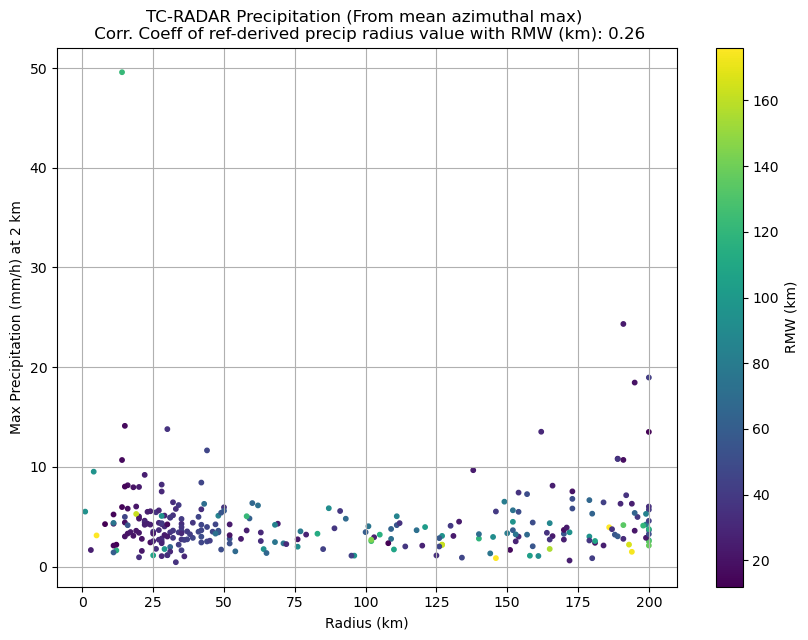

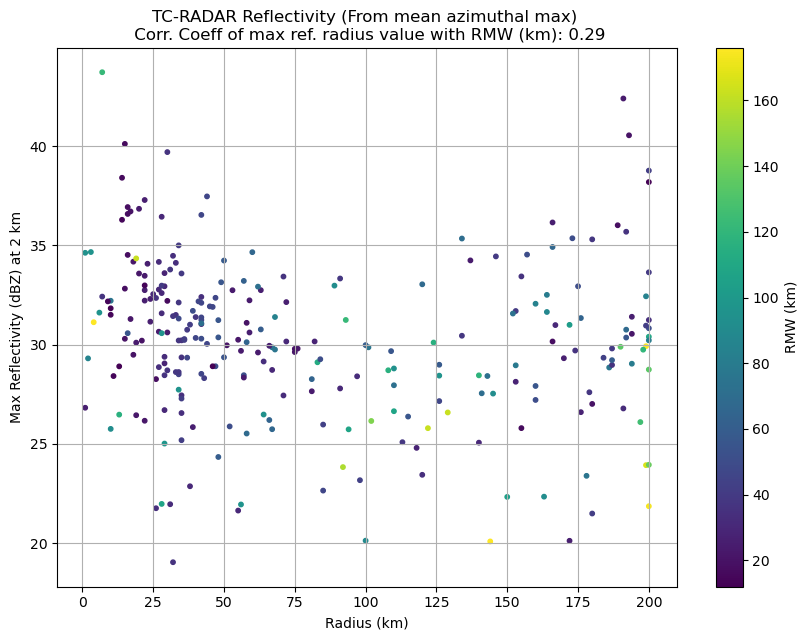

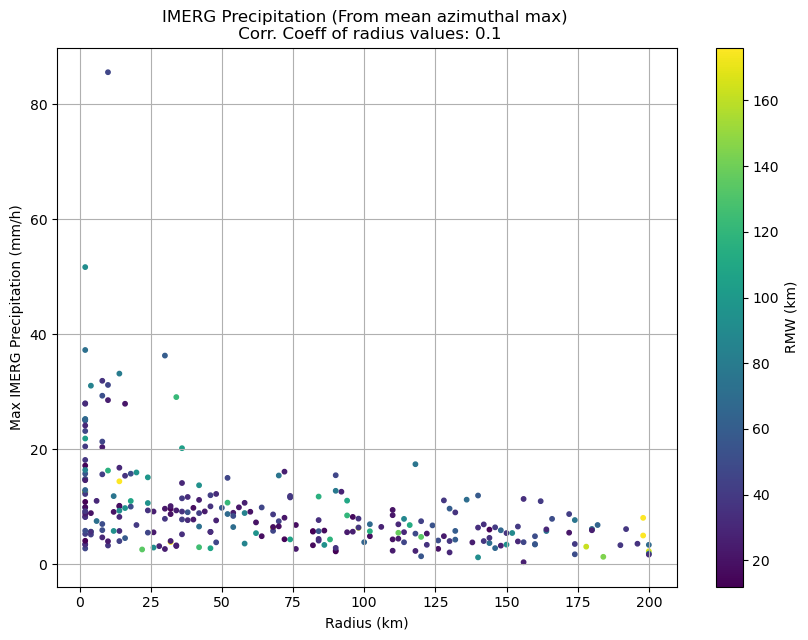

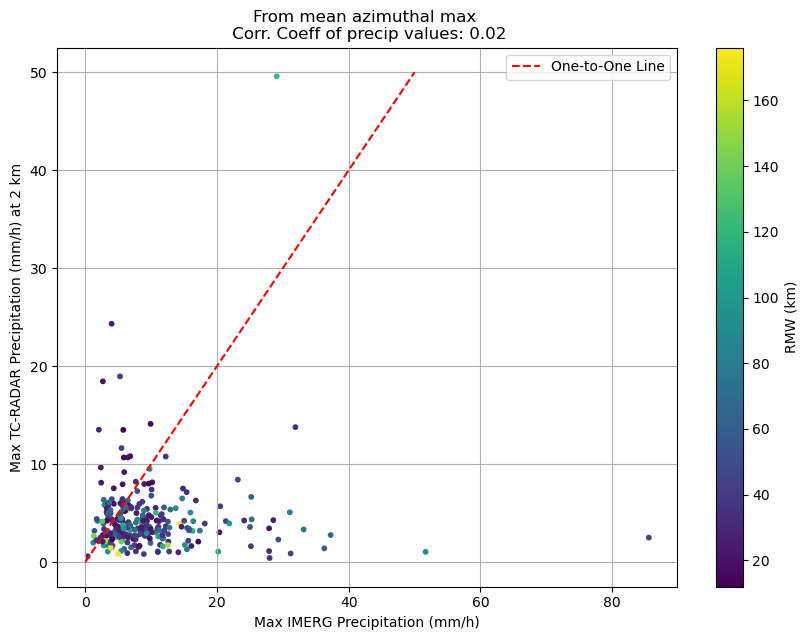

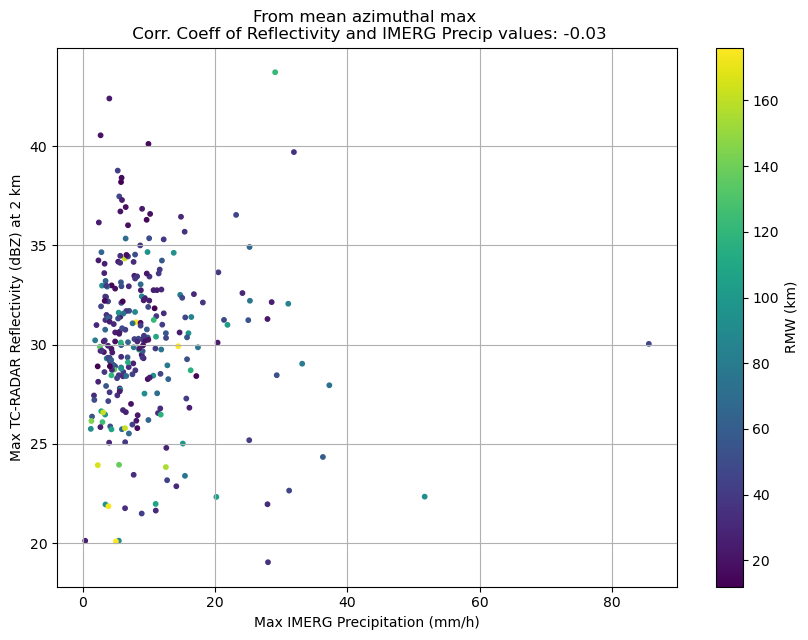

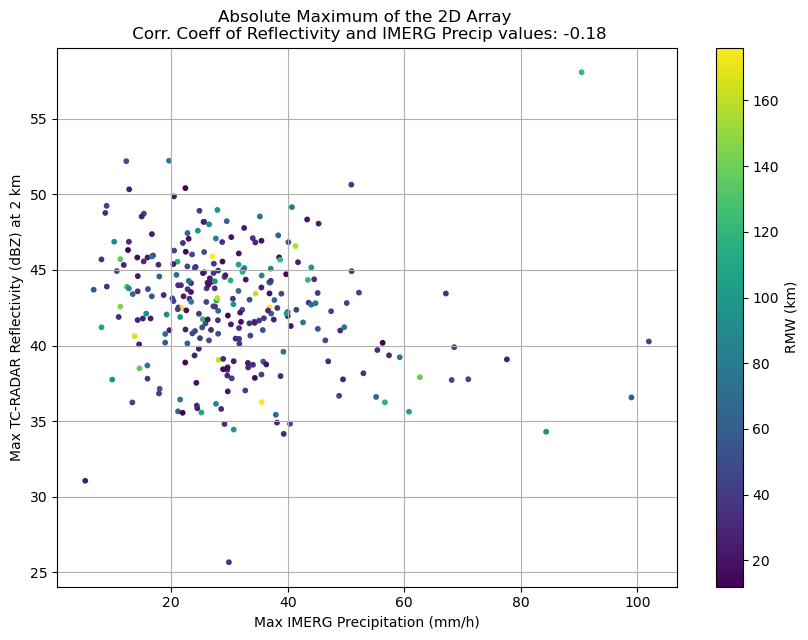

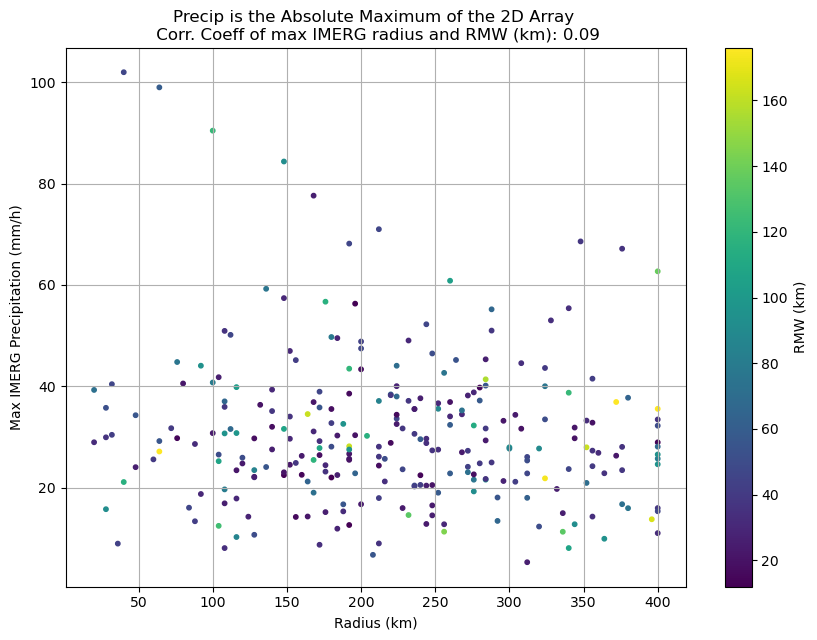

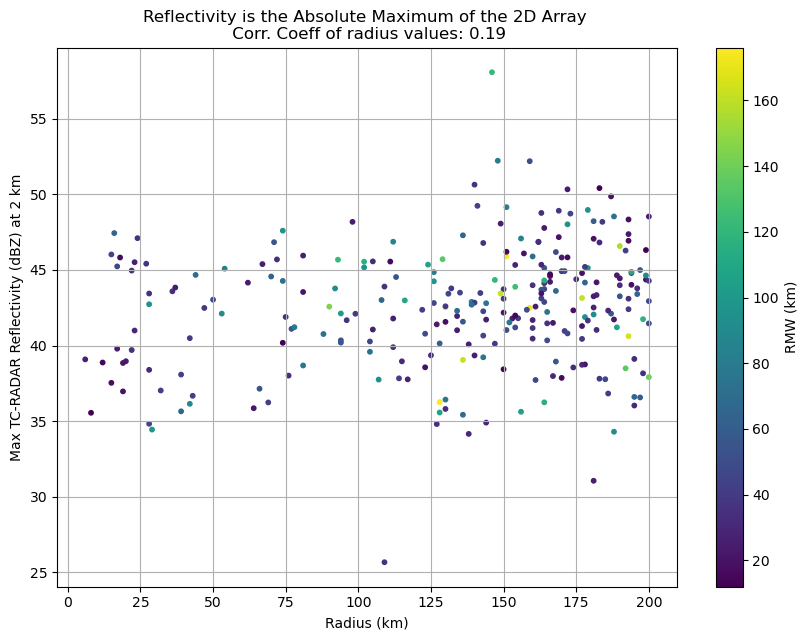

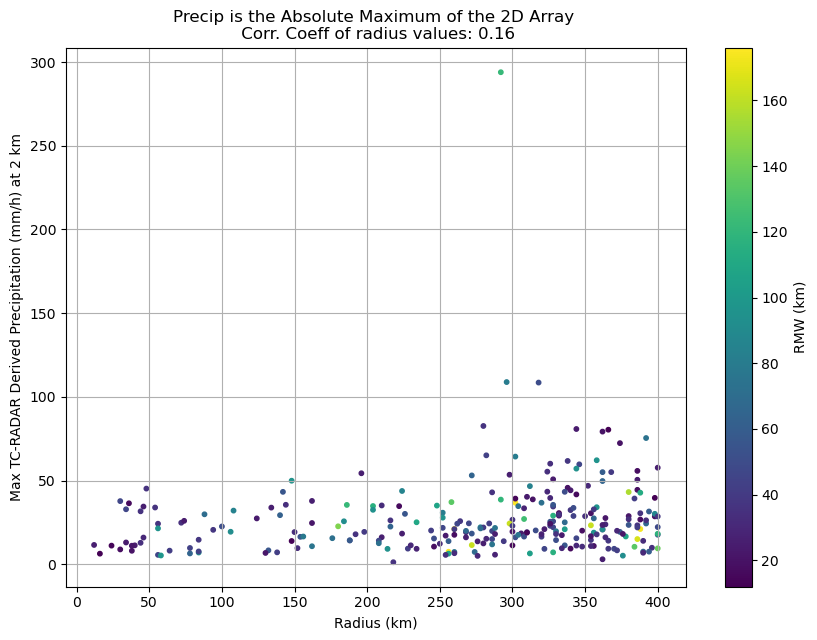

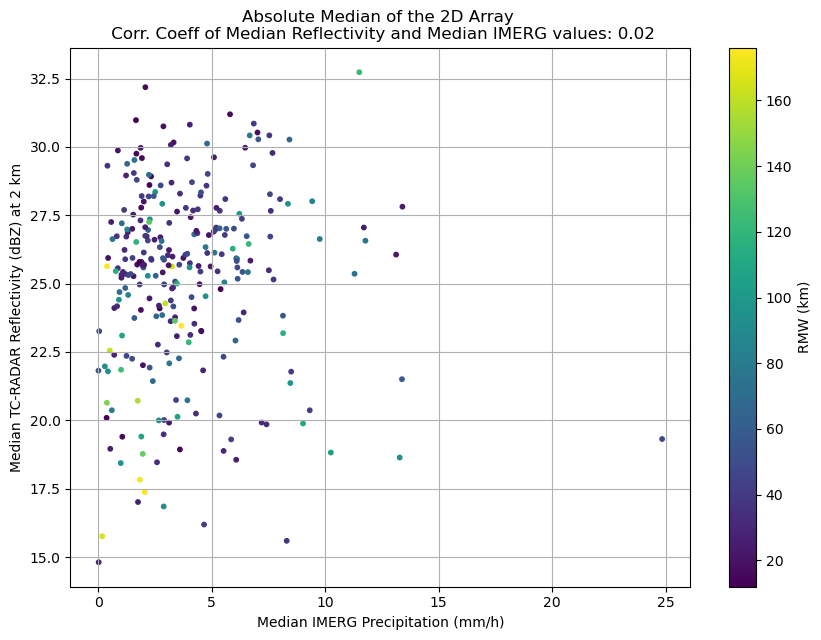

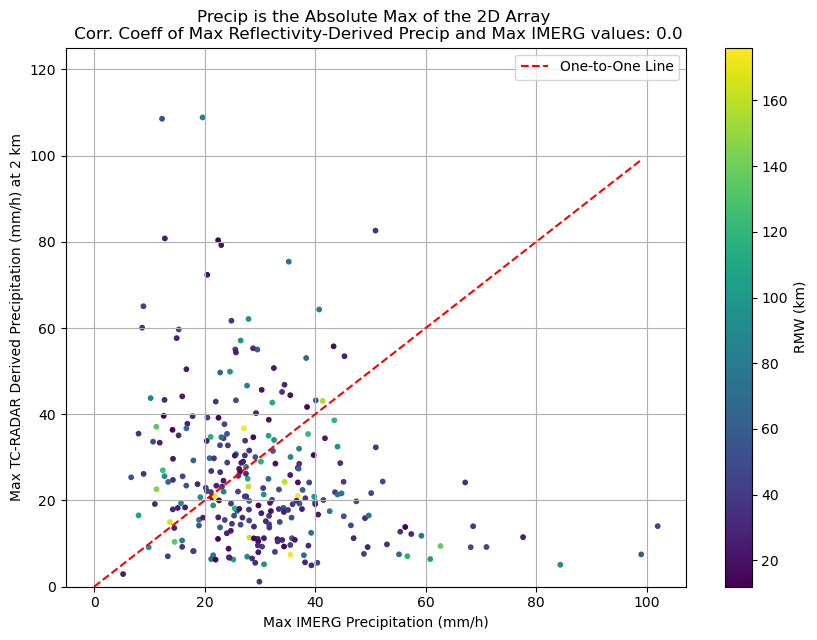

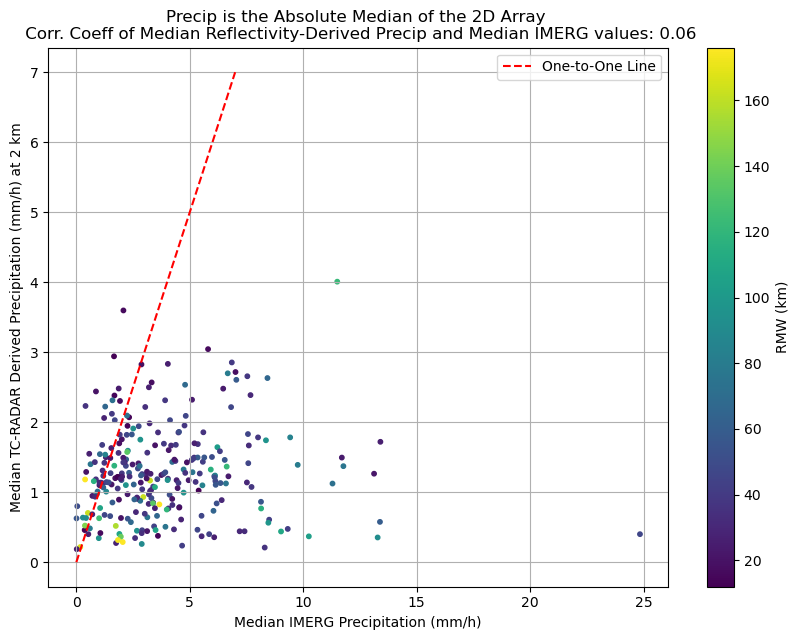

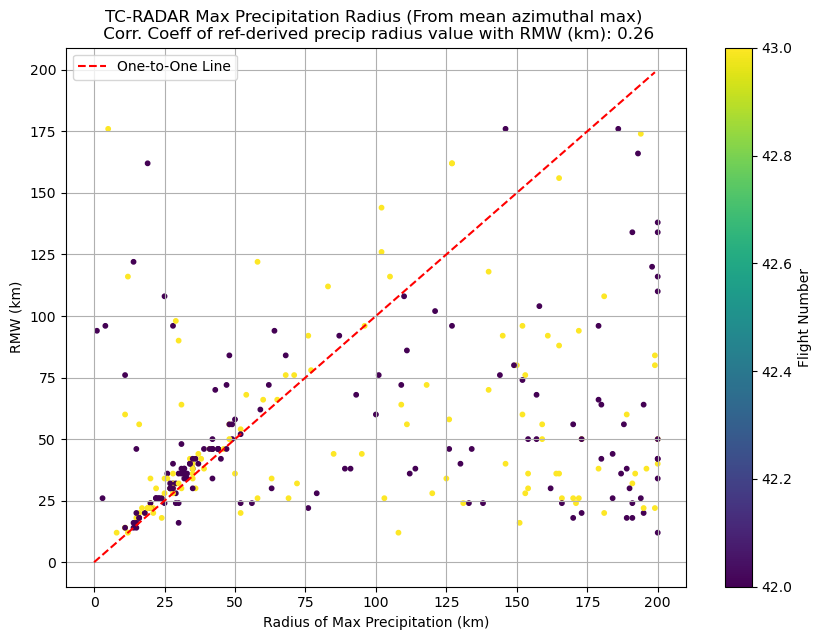

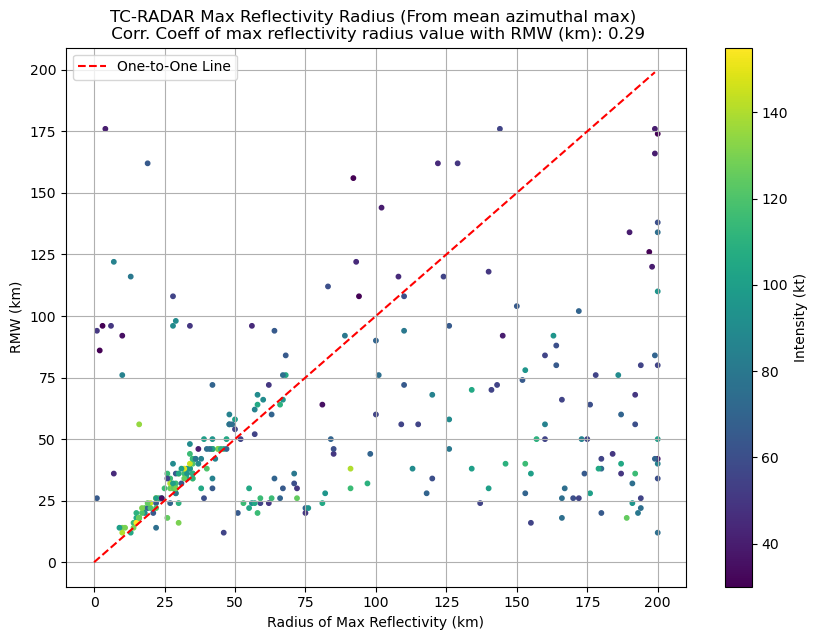

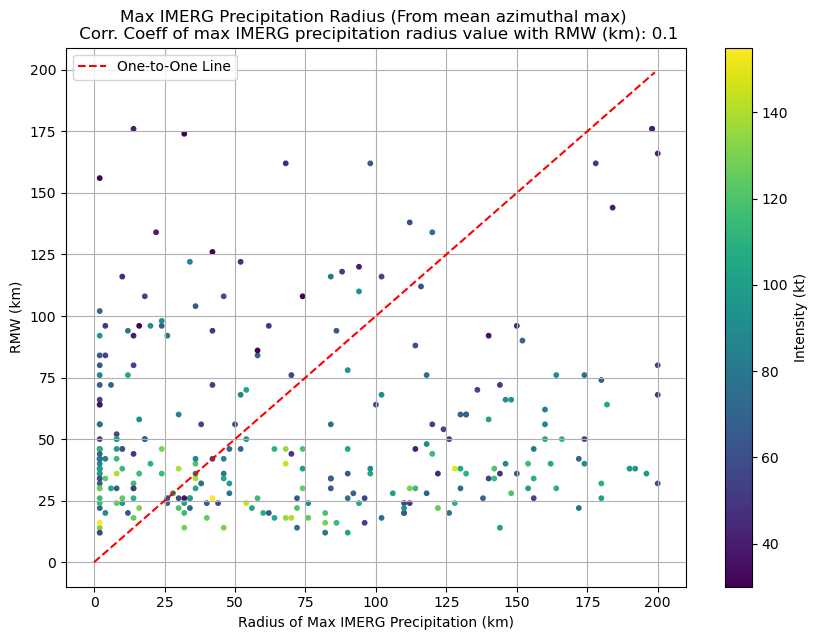

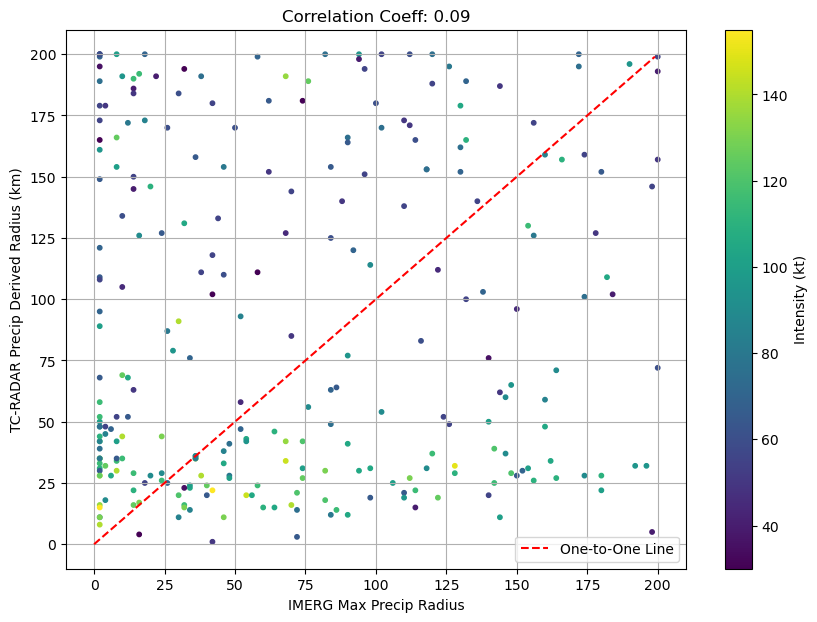

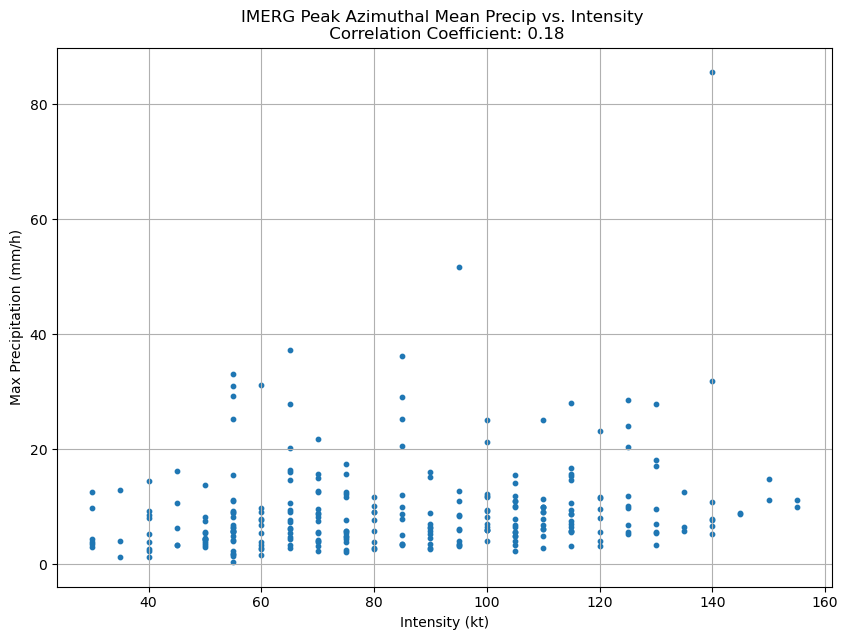

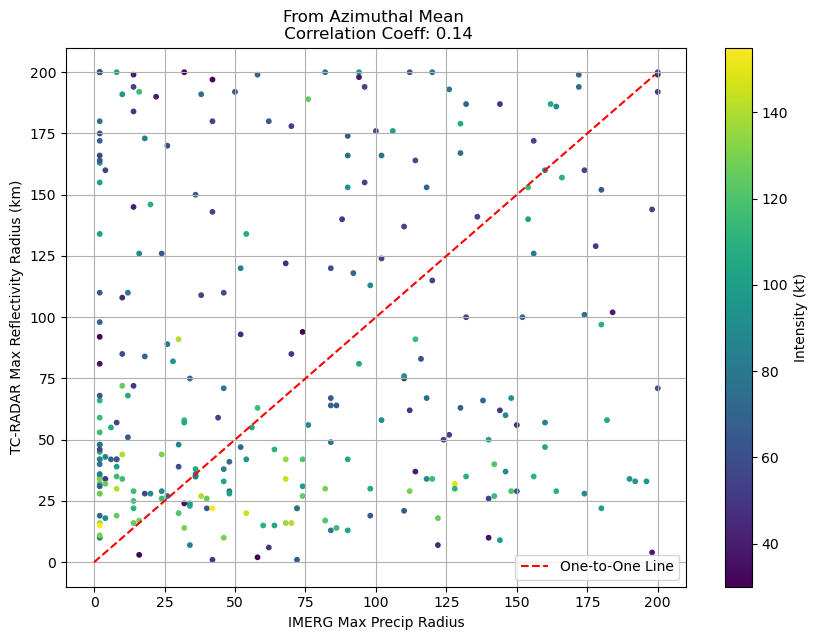

In [6]:
# Make scatter plots

# Convert lists to arrays        
rmw_arr = np.asarray(rmw_list)
vmax_arr = np.asarray(vmax_list)
pmin_arr = np.asarray(pmin_list)
year_arr = np.asarray(year_list)
flight_num_arr = np.asarray(flight_num_list)

data_color_mode = 'rmw'

if data_color_mode == 'rmw':
    data_mode = rmw_arr
    str_name = 'RMW (km)'
elif data_color_mode == 'vmax':
    data_mode = vmax_arr
    str_name = 'SHIPS Max Intensity (kt)'
elif data_color_mode == 'pmin':
    data_mode = pmin_arr
    str_name = 'SHIPS Minimum Central Pressure (hPa)'
elif data_color_mode == 'flight num':
    data_mode = flight_num_arr
    str_name = 'Flight Number'
elif data_color_mode == 'Year':
    data_mode = year_arr
    str_name = 'Year' 

cylindrical_rain_max_mean_pd = pd.DataFrame(cylindrical_rain_max_mean_list)
cylindrical_reflectivity_max_mean_pd = pd.DataFrame(cylindrical_reflectivity_max_mean_list)
cylindrical_imerg_max_mean_pd = pd.DataFrame(cylindrical_imerg_max_mean_list)

# Create slope = 1 line for comparison between precipitation values

y_lin = range(0,51)
x_lin = range(0,51)

plt.figure(figsize=(10,7))
plt.scatter(cylindrical_rain_max_mean_pd[1],cylindrical_rain_max_mean_pd[0],c=data_mode,s=10)
plt.ylabel('Max Precipitation (mm/h) at ' + str(height)+' km')
plt.xlabel('Radius (km)')

# Correlation of radius of max mean reflectivity-derived precip and TC-RADAR RMW at 2 km
max_mean_precip_rmw_data_mode_corr = np.corrcoef(cylindrical_rain_max_mean_pd[1],data_mode)[0][1]

plt.title('TC-RADAR Precipitation (From mean azimuthal max) \n Corr. Coeff of ref-derived precip radius value with '+
          str_name+': ' +
          str(round(max_mean_precip_rmw_data_mode_corr,2)))
plt.colorbar(label=str_name)
plt.grid()

plt.figure(figsize=(10,7))

# Correlation of radius of max mean reflectivity and TC-RADAR RMW at 2 km
max_mean_reflect_rmw_data_mode_corr = np.corrcoef(cylindrical_reflectivity_max_mean_pd[1],data_mode)[0][1]

plt.scatter(cylindrical_reflectivity_max_mean_pd[1],cylindrical_reflectivity_max_mean_pd[0],c=data_mode,s=10)
plt.xlabel('Radius (km)')
plt.ylabel('Max Reflectivity (dBZ) at ' + str(height)+' km')
plt.title('TC-RADAR Reflectivity (From mean azimuthal max) \n Corr. Coeff of max ref. radius value with ' +
          str_name+': ' +
          str(round(max_mean_reflect_rmw_data_mode_corr,2)))
plt.colorbar(label=str_name)
plt.grid()


plt.figure(figsize=(10,7))

# Correlation of radius of max mean IMERG Precip and TC-RADAR RMW at 2 km
max_mean_imerg_data_mode_corr = np.corrcoef(cylindrical_imerg_max_mean_pd[1],data_mode)[0][1]

plt.scatter(cylindrical_imerg_max_mean_pd[1],cylindrical_imerg_max_mean_pd[0],c=data_mode,s=10)
plt.ylabel('Max IMERG Precipitation (mm/h)')
plt.xlabel('Radius (km)')
plt.title('IMERG Precipitation (From mean azimuthal max) \n Corr. Coeff of radius values: ' +
          str(round(max_mean_imerg_data_mode_corr,2)))
plt.colorbar(label=str_name)
plt.grid()

plt.figure(figsize=(10,7))
# Find correlation between IMERG mean max precip and TC-RADAR derived mean max precip
mean_max_radar_imerg_corr = np.corrcoef(cylindrical_imerg_max_mean_pd[0],cylindrical_rain_max_mean_pd[0])[0][1]

plt.scatter(cylindrical_imerg_max_mean_pd[0],cylindrical_rain_max_mean_pd[0],c=data_mode,s=10)
plt.ylabel('Max TC-RADAR Precipitation (mm/h) at ' + str(height)+' km')
plt.xlabel('Max IMERG Precipitation (mm/h)')
plt.title('From mean azimuthal max \n Corr. Coeff of precip values: ' +
          str(round(mean_max_radar_imerg_corr,2)))
plt.plot(x_lin,y_lin,'--r',label='One-to-One Line')
plt.legend()
plt.grid()
plt.colorbar(label=str_name)

plt.figure(figsize=(10,7))
# Find correlation between IMERG mean max precip and TC-RADAR derived mean max precip
mean_max_radar_ref_imerg_corr = np.corrcoef(cylindrical_imerg_max_mean_pd[0],cylindrical_reflectivity_max_mean_pd[0])[0][1]

plt.scatter(cylindrical_imerg_max_mean_pd[0],cylindrical_reflectivity_max_mean_pd[0],c=data_mode,s=10)
plt.ylabel('Max TC-RADAR Reflectivity (dBZ) at ' + str(height)+' km')
plt.xlabel('Max IMERG Precipitation (mm/h)')
plt.title('From mean azimuthal max \n Corr. Coeff of Reflectivity and IMERG Precip values: ' +
          str(round(mean_max_radar_ref_imerg_corr,2)))
plt.grid()
plt.colorbar(label=str_name)


plt.figure(figsize=(10,7))
plt.scatter(max_IMERG_list,max_radar_reflectivity_list,c=data_mode,s=10)
max_imerg_max_ref_corr = np.corrcoef(max_IMERG_list,max_radar_reflectivity_list)[0][1]
plt.colorbar(label=str_name)
plt.ylabel('Max TC-RADAR Reflectivity (dBZ) at ' + str(height)+' km')
plt.xlabel('Max IMERG Precipitation (mm/h)')
plt.grid()
plt.title('Absolute Maximum of the 2D Array \n Corr. Coeff of Reflectivity and IMERG Precip values: ' +
          str(round(max_imerg_max_ref_corr,2)))

# a, b = np.polyfit(np.asarray(max_IMERG_list), np.asarray(max_radar_reflectivity_list),deg=1)
# # plt.plot(max_IMERG_list, a*np.asarray(max_IMERG_list)+b, color='steelblue', linestyle='--', linewidth=2)

# plt.text(1, 17, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=14)
plt.savefig('/Users/acheung/data/Figures/Radar_IMERG_Scatter/max_ref_precip.png')

plt.figure(figsize=(10,7))
plt.scatter(max_imerg_radius_list,max_IMERG_list,c=data_mode,s=10)
plt.colorbar(label=str_name)
# Correlation of radius of absolute max IMERG Precip and TC-RADAR RMW at 2 km
abs_max_imerg_radar_radius_corr = np.corrcoef(max_imerg_radius_list,data_mode)[0][1]
plt.xlabel('Radius (km)')
plt.ylabel('Max IMERG Precipitation (mm/h)')
plt.title('Precip is the Absolute Maximum of the 2D Array \n Corr. Coeff of max IMERG radius and '+
          str_name+': ' +
          str(round(abs_max_imerg_radar_radius_corr,2)))
plt.grid()


plt.figure(figsize=(10,7))
plt.scatter(max_ref_rad_list,max_radar_reflectivity_list,c=data_mode,s=10)
max_radar_rad_tc_rmw_corr = np.corrcoef(max_ref_rad_list,max_radar_reflectivity_list)[0][1]

plt.xlabel('Radius (km)')
plt.ylabel('Max TC-RADAR Reflectivity (dBZ) at ' + str(height)+' km')
plt.grid()
plt.colorbar(label=str_name)
plt.title('Reflectivity is the Absolute Maximum of the 2D Array \n Corr. Coeff of radius values: ' +
          str(round(max_radar_rad_tc_rmw_corr,2)))


plt.figure(figsize=(10,7))
plt.scatter(max_rain_radius_list,max_radar_derived_rain_list,c=data_mode,s=10)
max_radar_precip_tc_rmw_corr = np.corrcoef(max_rain_radius_list,max_radar_derived_rain_list)[0][1]
plt.xlabel('Radius (km)')
plt.title('Precip is the Absolute Maximum of the 2D Array \n Corr. Coeff of radius values: ' +
          str(round(max_radar_precip_tc_rmw_corr,2)))
plt.ylabel('Max TC-RADAR Derived Precipitation (mm/h) at ' + str(height)+' km')
plt.grid()
plt.colorbar(label=str_name)

# plt.title('2000-2019')

plt.figure(figsize=(10,7))
plt.scatter(med_IMERG_list,med_radar_reflectivity_list,c=data_mode,s=10)
med_tc_radar_ref_imerg_precip_corr = np.corrcoef(med_IMERG_list,med_radar_reflectivity_list)[0][1]

plt.ylabel('Median TC-RADAR Reflectivity (dBZ) at ' + str(height)+' km')
plt.xlabel('Median IMERG Precipitation (mm/h)')
plt.title('Absolute Median of the 2D Array \n Corr. Coeff of Median Reflectivity and Median IMERG values: ' +
          str(round(med_tc_radar_ref_imerg_precip_corr,2)))
plt.grid()
plt.colorbar(label=str_name)

# a = np.polyfit(med_IMERG_list, med_radar_reflectivity_list,deg=2)

# y = (a[0]*(np.asarray(max_IMERG_list)**2)) + (a[1]*(np.asarray(max_IMERG_list))) + (a[2])
    
# plt.scatter(max_IMERG_list, y, color='steelblue', linestyle='--', linewidth=2)
plt.savefig('/Users/acheung/data/Figures/Radar_IMERG_Scatter/med_ref_precip.png')

plt.figure(figsize=(10,7))
plt.scatter(max_IMERG_list,max_radar_derived_rain_list,c=data_mode,s=10)
plt.colorbar(label=str_name)
plt.ylabel('Max TC-RADAR Derived Precipitation (mm/h) at ' + str(height)+' km')
plt.xlabel('Max IMERG Precipitation (mm/h)')
max_tc_radar_precip_imerg_precip_corr = np.corrcoef(max_IMERG_list,max_radar_derived_rain_list)[0][1]

x_lin_2,y_lin_2 = range(0,100),range(0,100)

plt.plot(x_lin_2,y_lin_2,'--r',label='One-to-One Line')
plt.legend()
plt.grid()
plt.ylim(0,125)
plt.title('Precip is the Absolute Max of the 2D Array \n Corr. Coeff of Max Reflectivity-Derived Precip and Max IMERG values: ' +
          str(round(max_tc_radar_precip_imerg_precip_corr,2)))

# plt.title('2000-2019')
# plt.xticks(np.arange(0,np.ceil(np.nanmax([np.nanmax(max_IMERG_list),np.nanmax(max_radar_derived_rain_list)])),10))
# plt.yticks(np.arange(0,np.ceil(np.nanmax([np.nanmax(max_IMERG_list),np.nanmax(max_radar_derived_rain_list)])),10))

plt.savefig('/Users/acheung/data/Figures/Radar_IMERG_Scatter/max_precip_precip.png')



plt.figure(figsize=(10,7))
plt.scatter(med_IMERG_list,med_radar_derived_rain_list,c=data_mode,s=10)
median_tc_radar_precip_imerg_precip_corr = np.corrcoef(med_IMERG_list,med_radar_derived_rain_list)[0][1]


x_lin_3,y_lin_3 = range(0,8),range(0,8)

plt.plot(x_lin_3,y_lin_3,'--r',label='One-to-One Line')

plt.title('Precip is the Absolute Median of the 2D Array \n Corr. Coeff of Median Reflectivity-Derived Precip and Median IMERG values: ' +
          str(round(median_tc_radar_precip_imerg_precip_corr,2)))
plt.ylabel('Median TC-RADAR Derived Precipitation (mm/h) at ' + str(height)+' km')
plt.xlabel('Median IMERG Precipitation (mm/h)')
plt.grid()
plt.legend()
plt.colorbar(label=str_name)
plt.savefig('/Users/acheung/data/Figures/Radar_IMERG_Scatter/median_precip_precip.png')


# Plot scatter of TC-Radar Derived Precip Max Radius

plt.figure(figsize=(10,7))
plt.scatter(cylindrical_rain_max_mean_pd[1],data_mode,c=flight_num_arr,s=10)
plt.ylabel(str_name)
plt.xlabel('Radius of Max Precipitation (km)')

plt.title('TC-RADAR Max Precipitation Radius (From mean azimuthal max) \n Corr. Coeff of ref-derived precip radius value with '+
          str_name+': ' +
          str(round(max_mean_precip_rmw_data_mode_corr,2)))
x_lin_4,y_lin_4 = range(0,200),range(0,200)

plt.plot(x_lin_4,y_lin_4,'--r',label='One-to-One Line')
plt.legend()
plt.colorbar(label='Flight Number')
plt.grid()

# Plot scatter of TC-Radar Max Reflectivity Radius

plt.figure(figsize=(10,7))
plt.scatter(cylindrical_reflectivity_max_mean_pd[1],data_mode,c=vmax_arr,s=10)
plt.ylabel(str_name)
plt.xlabel('Radius of Max Reflectivity (km)')
plt.title('TC-RADAR Max Reflectivity Radius (From mean azimuthal max) \n Corr. Coeff of max reflectivity radius value with '+
          str_name+': ' +
          str(round(max_mean_reflect_rmw_data_mode_corr,2)))
plt.plot(x_lin_4,y_lin_4,'--r',label='One-to-One Line')
plt.colorbar(label='Intensity (kt)')
plt.grid()
plt.legend()

# Plot scatter of IMERG Max Precipitation Radius

plt.figure(figsize=(10,7))
plt.scatter(cylindrical_imerg_max_mean_pd[1],data_mode,c=vmax_arr,s=10)
plt.ylabel(str_name)
plt.xlabel('Radius of Max IMERG Precipitation (km)')
plt.title('Max IMERG Precipitation Radius (From mean azimuthal max) \n Corr. Coeff of max IMERG precipitation radius value with '+
          str_name+': ' +
          str(round(max_mean_imerg_data_mode_corr,2)))
plt.plot(x_lin_4,y_lin_4,'--r',label='One-to-One Line')
plt.colorbar(label='Intensity (kt)')
plt.grid()
plt.legend()

# Plot scatter of IMERG Max Precipitation Radius vs. TC-RADAR Precipitation Maximum

plt.figure(figsize=(10,7))
plt.scatter(cylindrical_imerg_max_mean_pd[1],cylindrical_rain_max_mean_pd[1],c=vmax_arr,s=10)
plt.ylabel('TC-RADAR Precip Derived Radius (km)')
plt.xlabel('IMERG Max Precip Radius')
plt.plot(x_lin_4,y_lin_4,'--r',label='One-to-One Line')
plt.colorbar(label='Intensity (kt)')
radar_imerg_radius_corr = np.corrcoef(cylindrical_imerg_max_mean_pd[1],cylindrical_rain_max_mean_pd[1])[0][1]
plt.title('Correlation Coeff: '+str(round(radar_imerg_radius_corr,2)))
plt.grid()
plt.legend()

# Make scatter plot of peak azimuthal mean precip vs. best-track intensity
plt.figure(figsize=(10,7))
imerg_intensity_corr = round(np.corrcoef(vmax_arr,cylindrical_imerg_max_mean_pd[0])[0][1],2)
plt.scatter(vmax_arr,cylindrical_imerg_max_mean_pd[0],s=10)
plt.title('IMERG Peak Azimuthal Mean Precip vs. Intensity \n Correlation Coefficient: ' + str(imerg_intensity_corr))
plt.ylabel('Max Precipitation (mm/h)')
plt.xlabel('Intensity (kt)')
plt.grid()

# Plot scatter of IMERG Max Precipitation Radius vs. TC-RADAR Reflectivity Maximum Radius

plt.figure(figsize=(10,7))
plt.scatter(cylindrical_imerg_max_mean_pd[1],cylindrical_reflectivity_max_mean_pd[1],c=vmax_arr,s=10)
plt.ylabel('TC-RADAR Max Reflectivity Radius (km)')
plt.xlabel('IMERG Max Precip Radius')
plt.plot(x_lin_4,y_lin_4,'--r',label='One-to-One Line')
plt.colorbar(label='Intensity (kt)')
radar_imerg_radius_corr = np.corrcoef(cylindrical_imerg_max_mean_pd[1],cylindrical_reflectivity_max_mean_pd[1])[0][1]
plt.title('From Azimuthal Mean \n Correlation Coeff: '+str(round(radar_imerg_radius_corr,2)))
plt.grid()
plt.legend()

In [18]:
rad_error_arr = abs(cylindrical_imerg_max_mean_pd[1]-cylindrical_reflectivity_max_mean_pd[1])
really_bad_cases = rad_error_arr.where(rad_error_arr > 100).dropna()
really_bad_cases

2      115.0
5      106.0
23     103.0
27     144.0
33     121.0
36     155.0
38     104.0
48     114.0
50     119.0
51     121.0
52     159.0
60     161.0
61     108.0
63     118.0
69     113.0
71     102.0
72     198.0
81     114.0
84     153.0
87     138.0
92     155.0
93     185.0
95     163.0
96     156.0
99     176.0
101    126.0
109    168.0
111    180.0
112    141.0
113    194.0
121    153.0
122    198.0
123    142.0
140    170.0
141    198.0
153    135.0
156    115.0
159    118.0
161    181.0
163    113.0
172    162.0
173    178.0
175    164.0
179    130.0
181    101.0
190    108.0
201    102.0
205    135.0
208    109.0
210    192.0
211    104.0
213    170.0
219    156.0
227    173.0
231    146.0
235    124.0
246    110.0
251    132.0
254    168.0
258    158.0
264    131.0
266    129.0
Name: 1, dtype: float64

In [8]:
vmax_arr = np.asarray(vmax_list)
pmin_arr = np.asarray(pmin_list)
year_arr = np.asarray(year_list)
flight_num_arr = np.asarray(flight_num_list)